In [53]:
from datetime import date
today = date.today()

In [54]:
#stock = ['SPY', 'GLD', 'SPLB', 'EEM', 'QQQ', 'SLV', 'HYG', 'VWO', 'TLT', 'FXI']
stock = ['SPY']
sampling = ['daily', 'weekly'][0]
aggregation = ['last_day', 'mean'][0]
#stock = ['VTI', 'VEU', 'VNQ', 'BND', 'GSG']
date_start = '2010-01-01'
date_end = today.strftime("%Y-%m-%d")

In [55]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas_datareader as pdr
import statsmodels.api as sm
import scipy.stats as scs

In [295]:
combined_data = []
for i in range(len(stock)):
    df = pdr.DataReader(stock[i], 
                       start=date_start, 
                       end=date_end, 
                       data_source='yahoo')
    name = stock[i]
    df_stock = df[['Adj Close']]
    df_stock = df_stock.rename(columns={"Adj Close" : name})
    if i > 0:
        combined_data = pd.concat([combined_data, df_stock], axis = 1)
    else:
        combined_data = df_stock
        
    
    #combined_data.append(df_stock)
    #combined_data.append(df_stock)
    #combined_data = pd.concat([combined_data, df_stock], axis=1, join="inner" )
    #df1.append(df4, ignore_index=True, sort=False)
    #result = pd.concat([df1, df4], axis=1, join="inner")
if sampling == 'weekly':
    if aggregation == 'last_day':
        combined_data = combined_data.resample('W').agg('last')
    elif aggregation == "mean":
        combined_data = combined_data.resample('W').agg('mean')

In [296]:
combined_data

,SPY
Date,
2010-01-04,91.087418
2010-01-05,91.328552
2010-01-06,91.392838
2010-01-07,91.778671
2010-01-08,92.084045
...,...
2021-02-12,392.640015
2021-02-16,392.299988
2021-02-17,392.390015


<AxesSubplot:xlabel='Date'>

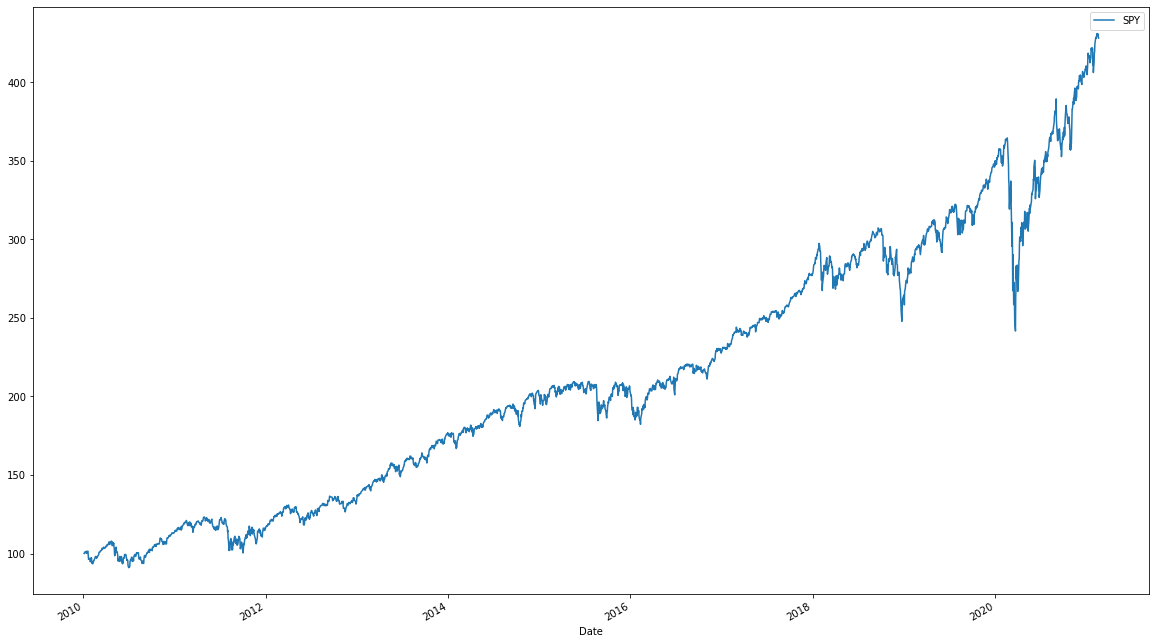

In [297]:
(combined_data / combined_data.iloc[0] * 100).plot(figsize=(20, 12))

In [298]:
combined_data['return'] = np.log(combined_data / combined_data.shift(1))
combined_data.dropna(inplace=True)
combined_data.head()

,SPY,return
Date,,
2010-01-05,91.328552,0.002644
2010-01-06,91.392838,0.000704
2010-01-07,91.778671,0.004213
2010-01-08,92.084045,0.003322
2010-01-11,92.212677,0.001396


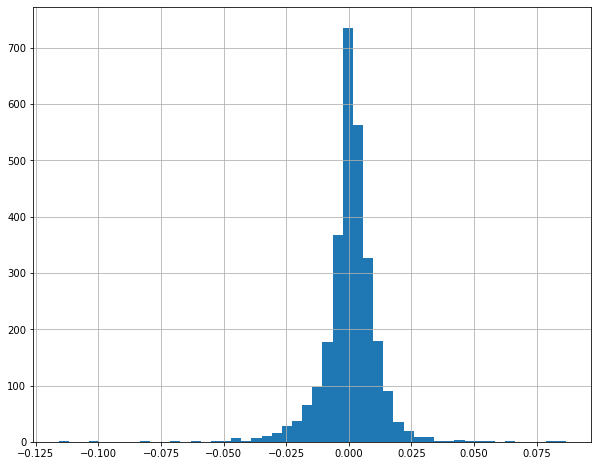

In [299]:
combined_data['return'].hist(bins=50, figsize=(10, 8));

# Linear Regression

In [300]:
lags = 3
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    combined_data[col] = combined_data['return'].shift(lag)
    cols.append(col)
combined_data.dropna(inplace=True)

In [427]:
from sklearn.metrics import accuracy_score
from sklearn import linear_model

In [302]:
combined_data_linear = combined_data.copy()
combined_data_linear

,SPY,return,lag_1,lag_2,lag_3
Date,,,,,
2010-01-08,92.084045,0.003322,0.004213,0.000704,0.002644
2010-01-11,92.212677,0.001396,0.003322,0.004213,0.000704
2010-01-12,91.352661,-0.009370,0.001396,0.003322,0.004213
2010-01-13,92.124229,0.008411,-0.009370,0.001396,0.003322
2010-01-14,92.373383,0.002701,0.008411,-0.009370,0.001396
...,...,...,...,...,...
2021-02-12,392.640015,0.004928,0.001614,-0.000436,-0.000666
2021-02-16,392.299988,-0.000866,0.004928,0.001614,-0.000436
2021-02-17,392.390015,0.000229,-0.000866,0.004928,0.001614


In [303]:
lim = linear_model.LinearRegression()

In [304]:
combined_data_linear['pos_ols_1'] = lim.fit(combined_data_linear[cols], combined_data_linear['return']).predict(combined_data_linear[cols])

In [305]:
combined_data_linear[['pos_ols_1']] = np.where(combined_data_linear[['pos_ols_1']] > 0, 1, -1)

In [306]:
combined_data_linear['pos_ols_1'].value_counts()

 1.0    1931
-1.0     867
Name: pos_ols_1, dtype: int64

In [307]:
combined_data_linear['strat_ols_1'] = combined_data_linear['pos_ols_1'] * combined_data_linear['return']

In [308]:
accuracy_score(combined_data_linear['pos_ols_1'],
               np.sign(combined_data_linear['return']))

0.5546819156540386

In [309]:
combined_data_linear[['return', 'strat_ols_1']].sum().apply(np.exp)

return         4.249680
strat_ols_1    9.247396
dtype: float64

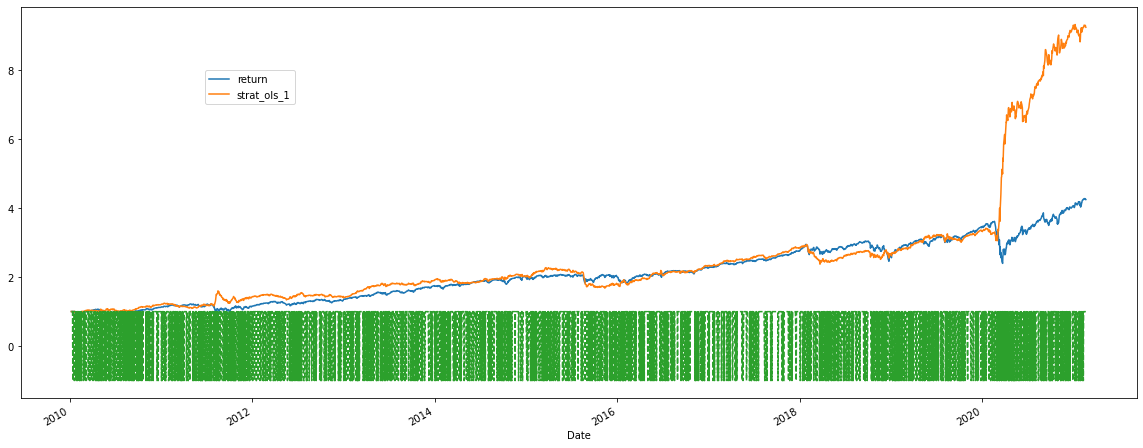

In [310]:
ax = combined_data_linear[['return', 'strat_ols_1']].cumsum().apply(np.exp).plot(
                                        figsize=(20, 8));
combined_data_linear['pos_ols_1'].plot(ax = ax, lw=1.5, secondary_y = 'Position', style = '--')
ax.get_legend().set_bbox_to_anchor((0.25,0.85));

# Logistic Regression

In [315]:
combined_data_logistic = combined_data.copy()

In [316]:
lm = linear_model.LogisticRegression(C=1e7, solver='lbfgs',
                                     multi_class='auto',
                                     max_iter=1000)

In [317]:
lm.fit(combined_data_logistic[cols], np.sign(combined_data_logistic['return']))

LogisticRegression(C=10000000.0, max_iter=1000)

In [318]:
combined_data_logistic['prediction'] = lm.predict(combined_data_logistic[cols])

In [319]:
combined_data_logistic['prediction'].value_counts()

 1.0    2745
-1.0      53
Name: prediction, dtype: int64

In [320]:
hits = np.sign(combined_data_logistic['return'].iloc[lags:] *
               combined_data_logistic['prediction'].iloc[lags:]
              ).value_counts()
hits

 1.0    1565
-1.0    1220
 0.0      10
dtype: int64

In [321]:
accuracy_score(combined_data_logistic['prediction'],
               np.sign(combined_data_logistic['return']))

0.5600428877769835

In [322]:
combined_data_logistic['strategy'] = combined_data_logistic['prediction'] * combined_data_logistic['return']

In [323]:
combined_data_logistic[['return', 'strategy']].sum().apply(np.exp)

return       4.249680
strategy    11.664222
dtype: float64

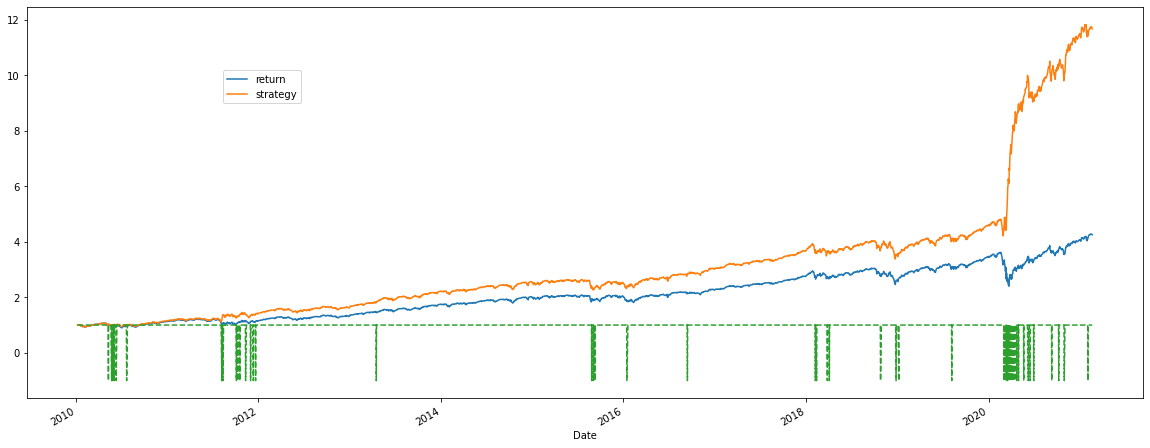

In [324]:
ax = combined_data_logistic[['return', 'strategy']].cumsum().apply(np.exp).plot(
                                        figsize=(20, 8));
combined_data_logistic['prediction'].plot(ax = ax, lw=1.5, secondary_y = 'Position', style = '--')
ax.get_legend().set_bbox_to_anchor((0.25,0.85));

Lets avoid overfitting

In [325]:
from sklearn.model_selection import train_test_split

In [337]:
train, test = train_test_split(combined_data_logistic, test_size=0.5,
                               shuffle=False, random_state=100)

In [338]:
train = train.copy().sort_index()
test = test.copy().sort_index()  

In [339]:
lm.fit(train[cols], np.sign(train['return']))

LogisticRegression(C=10000000.0, max_iter=1000)

In [340]:
test['prediction'] = lm.predict(test[cols])

In [341]:
test['prediction'].value_counts()

 1.0    1385
-1.0      13
 0.0       1
Name: prediction, dtype: int64

In [342]:
hits = np.sign(test['return'].iloc[lags:] *
               test['prediction'].iloc[lags:]
              ).value_counts()
hits

 1.0    778
-1.0    613
 0.0      5
dtype: int64

In [343]:
accuracy_score(test['prediction'],
               np.sign(test['return']))

0.5561115082201572

In [344]:
test['strategy'] = test['prediction'] * test['return']

In [345]:
test[['return', 'strategy']].sum().apply(np.exp)

return      2.060436
strategy    2.656908
dtype: float64

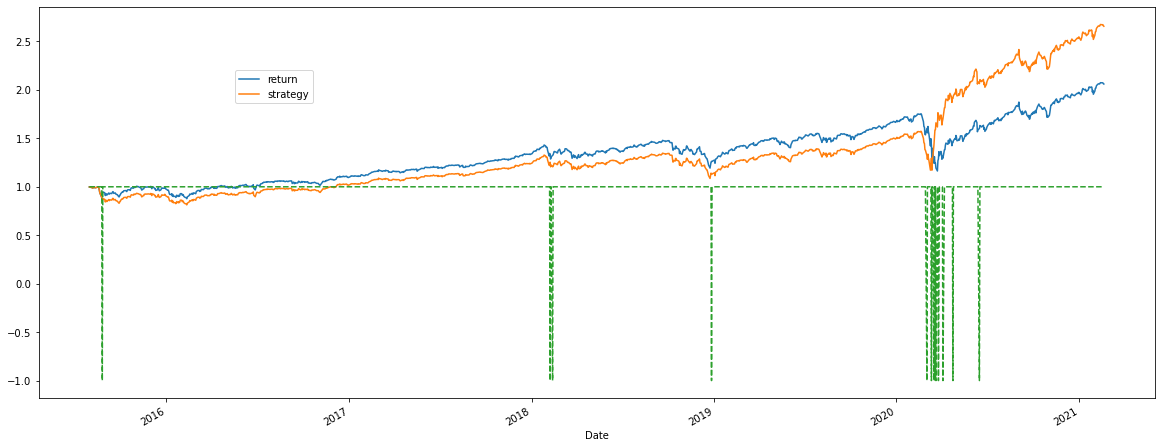

In [346]:
ax = test[['return', 'strategy']].cumsum().apply(np.exp).plot(
                                        figsize=(20, 8));
test['prediction'].plot(ax = ax, lw=1.5, secondary_y = 'Position', style = '--')
ax.get_legend().set_bbox_to_anchor((0.25,0.85));

# K-Fold Cross Validation

In [430]:
k = 4
num_val_samples = len(combined_data_logistic) // k

all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = combined_data_logistic[cols][i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = np.sign(combined_data_logistic['return'])[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [combined_data_logistic[cols][:i * num_val_samples],
         combined_data_logistic[cols][(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [np.sign(combined_data_logistic['return'])[:i * num_val_samples],
         np.sign(combined_data_logistic['return'])[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    lm = linear_model.LogisticRegression(C=1e7, solver='lbfgs',
                                     multi_class='auto',
                                     max_iter=1000)
    # Train the model (in silent mode, verbose=0)
    lm.fit(partial_train_data, np.sign(partial_train_targets))
    # Evaluate the model on the validation data
    val_data['prediction'] = lm.predict(val_data)
    val_data['return'] =  combined_data_logistic['return'][i * num_val_samples: (i + 1) * num_val_samples]
    ac = accuracy_score(val_data['prediction'], np.sign(val_data['return']))
    all_scores.append(ac)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [432]:
all_scores

[0.5493562231759657,
 0.5636623748211731,
 0.5436337625178826,
 0.5765379113018598]

# Clustering

In [262]:
combined_data_logistic

,SPY,return,lag_1,lag_2,lag_3,pos_ols_1,strat_ols_1,prediction,strategy,pos_clus
Date,,,,,,,,,,
2010-01-08,92.084045,0.003322,0.004213,0.000704,0.002644,1.0,0.003322,1.0,0.003322,-1
2010-01-11,92.212677,0.001396,0.003322,0.004213,0.000704,1.0,0.001396,1.0,0.001396,-1
2010-01-12,91.352661,-0.009370,0.001396,0.003322,0.004213,1.0,-0.009370,1.0,-0.009370,-1
2010-01-13,92.124229,0.008411,-0.009370,0.001396,0.003322,1.0,0.008411,1.0,0.008411,-1
2010-01-14,92.373383,0.002701,0.008411,-0.009370,0.001396,-1.0,-0.002701,1.0,0.002701,1
...,...,...,...,...,...,...,...,...,...,...
2021-02-12,392.640015,0.004928,0.001614,-0.000436,-0.000666,1.0,0.004928,1.0,0.004928,-1
2021-02-16,392.299988,-0.000866,0.004928,0.001614,-0.000436,1.0,-0.000866,1.0,-0.000866,-1
2021-02-17,392.390015,0.000229,-0.000866,0.004928,0.001614,1.0,0.000229,1.0,0.000229,-1


In [253]:
from sklearn.cluster import KMeans

In [254]:
model = KMeans(n_clusters=3, random_state=0)  #  <1>

In [286]:
model.fit(combined_data_logistic[cols])

KMeans(n_clusters=3, random_state=0)

In [287]:
combined_data_logistic['pos_clus'] = model.predict(combined_data_logistic[cols])

In [288]:
combined_data_logistic['pos_clus'] = np.where(combined_data_logistic['pos_clus'] == 2, -1, 1) 

In [289]:
combined_data_logistic['pos_clus'].values

array([1, 1, 1, ..., 1, 1, 1])

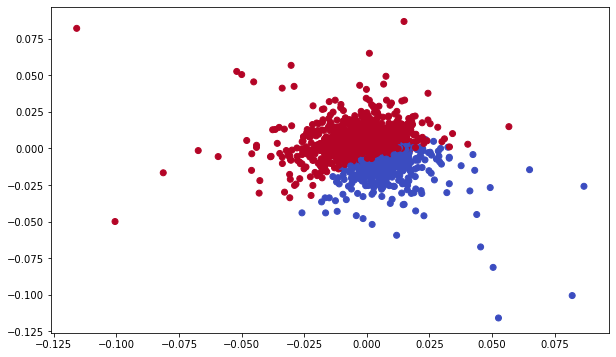

In [290]:
plt.figure(figsize=(10, 6))
plt.scatter(combined_data_logistic[cols].iloc[:, 0], combined_data_logistic[cols].iloc[:, 1],
            c=combined_data_logistic['pos_clus'], cmap='coolwarm');

In [291]:
combined_data_logistic['strat_clus'] = combined_data_logistic['pos_clus'] * combined_data_logistic['return']

In [292]:
combined_data_logistic[['return', 'strat_clus']].sum().apply(np.exp)

return        4.249680
strat_clus    5.750311
dtype: float64

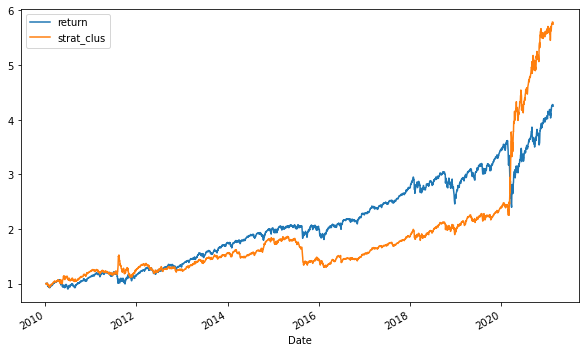

In [293]:
combined_data_logistic[['return', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10, 6));